In [1]:
import stim
import numpy as np
from numpy.linalg import matrix_power, matrix_rank
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sinter
from mec import make_circle
from typing import List
import pymatching
import galois
from ldpc import bp_decoder, bposd_decoder
from tqdm import tqdm
from collections import Counter

In [123]:

# code = [5,18,10,3,2,0,7,14,5,18,3,1]
code = [15,3,12,1,2,0,14,1,3,15,2,4]  # one I found
# code = [3,15,5,0,2,2,1,8,3,15,3,3]
code = [15,3,9,1,2,0,2,7,3,15,2,0]  # one from the paper
# code = [6,12,3,1,2,3,1,2,12,6,0,4]
code = [15,3,6,1,2,3,13,5,15,3,1,5]

In [124]:
def cyclic_shift_matrix(l):
    arr = np.eye(l, dtype=int)
    return np.roll(arr, axis=1, shift=1)

ell = code[0]
m = code[1]

x = np.kron(cyclic_shift_matrix(ell), np.eye(m))
y = np.kron(np.eye(ell), cyclic_shift_matrix(m))

A1 = matrix_power(x, code[2])
A2 = matrix_power(y, code[3])
A3 = matrix_power(y, code[4])
A = ( A1 + A2 + A3 ) % 2

B1 = matrix_power(y, code[5])
B2 = matrix_power(x, code[6])
B3 = matrix_power(x, code[7])
B = ( B1 + B2 + B3 ) % 2

Hx = np.hstack([A, B]).astype(int)
Hz = np.hstack([B.T, A.T]).astype(int)

GF = galois.GF(2)
arr = GF(Hz.T)
k = 2 * (Hz.T.shape[1] - matrix_rank(arr))

In [125]:
def par2gen(H):
    GF = galois.GF(2)
    gfH = GF(H)
    gfH_rank = np.linalg.matrix_rank(gfH)

    rref_H = gfH.row_reduce()

    swaps = []
    col_H = rref_H.copy()
    for i in range(gfH_rank):
        inds = np.where(col_H[i])[0]
        pivot = inds[0]
        col_H[:,[i,pivot]] = col_H[:,[pivot,i]]
        swaps.append((i,pivot))

    col_H = col_H[:gfH_rank]
    col_G = GF(np.hstack([col_H[:,gfH_rank:].T, np.eye(H.shape[1]-gfH_rank, dtype=int)]))

    G = col_G.copy()
    for swap in swaps[::-1]:
        G[:,[swap[1],swap[0]]] = G[:,[swap[0],swap[1]]]

    if (np.any(G @ rref_H[:gfH_rank].T) or np.any(col_G @ col_H.T)):
        print("FAILED")
        return
    return (np.array(G, dtype=int), np.array(col_G, dtype=int))

def commute(x, z, n):
    # 0 if commute, 1 if anticommute
    x1 = x[:n]
    x2 = x[n:]
    z1 = z[:n]
    z2 = z[n:]
    return (x1 @ z2 % 2) ^ (x2 @ z1 % 2)


def SGSOP(Gx, Gz, n):
    # symplectic gram-schmidt orthogonalization procedure
    sym_Gx = np.hstack([Gx, np.zeros(Gx.shape, dtype=int)])
    sym_Gz = np.hstack([np.zeros(Gz.shape, dtype=int), Gz])
    sym_G = np.vstack([sym_Gx, sym_Gz])
    logicals = []
    generators = []

    while(sym_G.shape[0]):
        g1 = sym_G[0]

        commutes = True
        for i in range(1, sym_G.shape[0]-1):
            g2 = sym_G[i]
            if (commute(g1,g2,n)):
                logicals.append((g1, g2))
                sym_G = np.delete(sym_G, [0, i], axis=0)

                for j in range(sym_G.shape[0]):
                    gj = sym_G[j]
                    sym_G[j] = gj ^ (commute(gj,g2,n) * g1) ^ (commute(gj,g1,n) * g2)
                commutes = False
                break

        if commutes:
            generators.append(g1)
            sym_G = np.delete(sym_G, 0, axis=0)

    return (logicals, generators)

In [126]:
def get_logicals(gen_type=False):
    n = Hx.shape[1]
    Gx, col_Gx = par2gen(Hx)
    Gz, col_Gz = par2gen(Hz)
    logicals, generators = SGSOP(Gx, Gz, n)

    logX = np.array([l[1][n:] for l in logicals])
    logZ = np.array([l[0][:n] for l in logicals])

    if gen_type: return logX
    else: return logZ

In [127]:
def embed_code(code, init):
    emb_m, emb_ell, A_ind, B_ind = code

    lattice = np.empty((2*emb_m, 2*emb_ell), dtype=object)
    lattice[0][0] = f"x{init}"

    # As = [[A1, A2.T], [A2, A3.T], [A1, A3.T]]
    # Bs = [[B1, B2.T], [B2, B3.T], [B1, B3.T]]
    As = [[A1, A2.T], [A2, A1.T], [A2, A3.T], [A3, A2.T], [A1, A3.T], [A3, A1.T]]
    Bs = [[B1, B2.T], [B2, B1.T], [B2, B3.T], [B3, B2.T], [B1, B3.T], [B3, B1.T]]

    def get_nbr(i, j):
        if (i % 2 == 0):
            if (j % 2 == 0):
                return "x"
            else:
                return "r"
        else:
            if (j % 2 == 0):
                return "l"
            else:
                return "z"

    for i in range(2*emb_m - 1):
        for j in range(2*emb_ell):
            curr_ind = int(lattice[i][j][1:])

            if (i % 2 == 0):
                tmp_A = As[A_ind][1]
            else:
                tmp_A = As[A_ind][0]
            if (j % 2 == 0):
                tmp_B = Bs[B_ind][1]
            else:
                tmp_B = Bs[B_ind][0]

            lattice[(i+1)%(2*emb_m)][j] = f"{get_nbr((i+1)%(2*emb_m), j)}{np.where(tmp_A @ np.eye(m*ell)[curr_ind])[0][0]}"
            lattice[i][(j+1)%(2*emb_ell)] = f"{get_nbr(i, (j+1)%(2*emb_ell))}{np.where(tmp_B @ np.eye(m*ell)[curr_ind])[0][0]}"

    for i in range(2*emb_m):
        for j in range(2*emb_ell):
            if (lattice[i][j][0] == "z"):
                lattice[i][j] = f"z{int(lattice[i][j][1:]) + m*ell}"
            elif (lattice[i][j][0] == "r"):
                lattice[i][j] = f"r{int(lattice[i][j][1:]) + m*ell}"

    return lattice

lattice = embed_code((code[8],code[9],code[10],code[11]), 0)

In [128]:
all_qbts = {}

qbts = np.array([None for i in range(2*m*ell)])
for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "r" or lattice[i][j][0] == "l":
            all_qbts[(i,j)] = int(lattice[i][j][1:])
            qbts[int(lattice[i][j][1:])] = (i, j)
x_checks = np.array([None for i in range(m*ell)])
z_checks = np.array([None for i in range(m*ell)])

for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "x":
            all_qbts[(i,j)] = int(lattice[i][j][1:]) + 2*m*ell
            x_checks[int(lattice[i][j][1:])] = (i, j)
        elif lattice[i][j][0] == "z":
            all_qbts[(i,j)] = int(lattice[i][j][1:]) + 2*m*ell
            z_checks[int(lattice[i][j][1:])-(m*ell)] = (i, j)

x_rs = []
z_rs = []
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    x_rs.append(make_circle(gen_qbts)[2])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    z_rs.append(make_circle(gen_qbts)[2])

lr_x_checks = []
sr_x_checks = []
lr_z_checks = []
sr_z_checks = []

for i, x_check in enumerate(x_checks):
    gen_qbts = qbts[np.where(Hx[i])[0]]

    nonlocal_qbts = []
    if (x_rs[i] > (min(x_rs)+np.std(x_rs))):
        lr_x_checks.append(i)
    else:
        sr_x_checks.append(i)

for i, z_check in enumerate(z_checks):
    gen_qbts = qbts[np.where(Hz[i])[0]]

    nonlocal_qbts = []
    if (z_rs[i] > min(z_rs)+np.std(z_rs)):
        lr_z_checks.append(i)
    else:
        sr_z_checks.append(i)

In [129]:
# def get_ancilla_allocations():
#     gens = []
#     for i, x in enumerate(lr_x_checks):
#         x_check = x_checks[x]
#         gen_qbts = qbts[np.where(Hx[x])[0]]

#         nonlocal_qbts = []
#         for qbt in gen_qbts:
#             if (abs(qbt[0] - x_check[0]) + abs(qbt[1] - x_check[1])) > 2*m:
#                 nonlocal_qbts.append(qbt)
#         gens.append([nonlocal_qbts, x_checks[x]])

#     for i, z in enumerate(lr_z_checks):
#         z_check = z_checks[z]
#         gen_qbts = qbts[np.where(Hz[z])[0]]

#         nonlocal_qbts = []
#         for qbt in gen_qbts:
#             if (abs(qbt[0] - z_check[0]) + abs(qbt[1] - z_check[1])) > 2*m:
#                 nonlocal_qbts.append(qbt)
#         gens.append([nonlocal_qbts, z_checks[z]])

#     anc_alloc = {}
#     for gen in gens:
#         anc_alloc[gen[1]] = len(gen[0])
#     c = Counter(list(itertools.chain(*[gen[0] for gen in gens])))
#     for qbt, anc in c.items():
#         anc_alloc[qbt] = anc

#     return anc_alloc

In [130]:
def manhattan(qbts):
    p, q = qbts
    return np.abs(p[0]-q[0])+np.abs(p[1]-q[1])

def measure_x_checks(checks, scale=False):
    c = stim.Circuit()
    c.append("DEPOLARIZE1", [all_qbts[x_checks[x_check]] for x_check in checks], 0.001)
    for x in checks:
        gen_qbts = qbts[np.where(Hx[x])[0]]
        for qbt in gen_qbts:
            path_qbts = [all_qbts[x_checks[x]], all_qbts[qbt]]
            c.append("CNOT", path_qbts)
            if scale:
                c.append("DEPOLARIZE2", path_qbts, 0.001*manhattan([x_checks[x], qbt]))
            else:
                c.append("DEPOLARIZE2", path_qbts, 0.001)
    c.append("H", [all_qbts[x_checks[x_check]] for x_check in checks])
    c.append("DEPOLARIZE1", [all_qbts[x_checks[x_check]] for x_check in checks], 0.001)
    return c

def measure_z_checks(checks, scale=False):
    c = stim.Circuit()
    for z in checks:
        gen_qbts = qbts[np.where(Hz[z])[0]]
        for qbt in gen_qbts:
            path_qbts = [all_qbts[qbt], all_qbts[z_checks[z]]]
            c.append("CNOT", path_qbts)
            if scale:
                c.append("DEPOLARIZE2", path_qbts, 0.001*manhattan([qbt, z_checks[z]]))
            else:
                c.append("DEPOLARIZE2", path_qbts, 0.001)
    return c

def all_checks():
    c = stim.Circuit()
    c += measure_z_checks(sr_z_checks, True)
    c += measure_z_checks(lr_z_checks, False)
    c += measure_x_checks(sr_x_checks, True)
    c += measure_x_checks(lr_x_checks, False)
    return c

In [131]:
def init_detectors():
    c = stim.Circuit()
    for i, z_check in enumerate(z_checks):
        coord = z_check
        c.append("DETECTOR", [stim.target_rec(-(m*ell)+i)], (coord[0], coord[1], 0))
    return c

def inter_detectors(type, checks, meas_offset, prev_meas_offset): # false for z
    c = stim.Circuit()
    for i, check in enumerate(checks):
        coord = x_checks[check] if type else z_checks[check]
        c.append("DETECTOR", [stim.target_rec(-meas_offset+i), stim.target_rec(-prev_meas_offset+i)], (coord[0], coord[1], 0))
    return c

def observables(type):
    c = stim.Circuit()
    for i, logical in enumerate(get_logicals(type)):
        incl_qbts = np.where(logical)[0]
        incl_qbts = [-j-1 for j in incl_qbts]
        c.append("OBSERVABLE_INCLUDE", [stim.target_rec(j) for j in incl_qbts], i)
    return c

def final_detectors():
    c = stim.Circuit()
    for i, z_check in enumerate(z_checks):
        coord = z_check
        incl_qbts = np.where(Hz[i])[0]
        incl_qbts = [-j-1 for j in incl_qbts]
        c.append("DETECTOR", [stim.target_rec(-(3*m*ell)+i)]+[stim.target_rec(j) for j in incl_qbts], (coord[0], coord[1], 1))
    c += observables()
    return c

In [138]:
num_rounds = 20
lr_time = 5
num_gen_meas = []

c = stim.Circuit()
for key, value in all_qbts.items():
    c.append("QUBIT_COORDS", value, (key[0],key[1],0))
c.append("R", [qbt for qbt in all_qbts.values()])

c += all_checks().without_noise()
c.append("MR", [all_qbts[z_check] for z_check in z_checks])
c.append("MR", [all_qbts[x_check] for x_check in x_checks])
num_gen_meas.append(2*m*ell)

def sr_round():
    c = stim.Circuit()

    c += measure_z_checks(sr_z_checks, False)
    c += measure_x_checks(sr_x_checks, False)

    c.append("X_ERROR", [all_qbts[z_checks[z_check]] for z_check in sr_z_checks], 0.001)
    c.append("X_ERROR", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks], 0.001)
    c.append("MR", [all_qbts[z_checks[z_check]] for z_check in sr_z_checks])
    c.append("MR", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks])
    c.append("X_ERROR", [all_qbts[z_checks[z_check]] for z_check in sr_z_checks], 0.001)
    c.append("X_ERROR", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks], 0.001)

    c += inter_detectors(False, sr_z_checks, len(sr_z_checks+sr_x_checks), num_gen_meas[-1]+len(sr_z_checks+sr_x_checks))
    # c += inter_detectors(True, sr_x_checks, l+l2+num_gen_meas[-1][1]+len(sr_z_checks+sr_x_checks))

    num_gen_meas.append(len(sr_z_checks+sr_x_checks))

    return c

def lr_round():
    c = stim.Circuit()

    c += measure_z_checks(sr_z_checks, False)
    c += measure_z_checks(lr_z_checks, False)
    c += measure_x_checks(sr_x_checks, False)
    c += measure_x_checks(lr_x_checks, False)

    c.append("X_ERROR", [all_qbts[z_checks[z_check]] for z_check in sr_z_checks+lr_z_checks], 0.001)
    c.append("X_ERROR", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks+lr_x_checks], 0.001)
    c.append("MR", [all_qbts[z_checks[z_check]] for z_check in sr_z_checks+lr_z_checks])
    c.append("MR", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks+lr_x_checks])
    c.append("X_ERROR", [all_qbts[z_checks[z_check]] for z_check in sr_z_checks+lr_z_checks], 0.001)
    c.append("X_ERROR", [all_qbts[x_checks[x_check]] for x_check in sr_x_checks+lr_x_checks], 0.001)


    last_lr = len(num_gen_meas) - num_gen_meas[::-1].index(2*m*ell) - 1
    tot_gens = sum(num_gen_meas[last_lr+1:])

    c += inter_detectors(False, sr_z_checks, 2*m*ell, num_gen_meas[-1]+2*m*ell)
    c += inter_detectors(False, lr_z_checks, 2*m*ell-len(sr_z_checks), tot_gens+3*m*ell+len(lr_z_checks))

    num_gen_meas.append(2*m*ell)
    return c


for i in range(1,num_rounds+1):
    c.append("SHIFT_COORDS", [], (0,0,1))
    c.append("DEPOLARIZE1", [all_qbts[qbt] for qbt in qbts], 0.001)
    if (i%lr_time==0): c += lr_round()
    else: c += sr_round()

c += lr_round().without_noise()
c.append("M",[all_qbts[qbt] for qbt in qbts[::-1]])
c += observables(False)

In [139]:
np.set_printoptions(linewidth=200)
detector_sampler = c.without_noise().compile_detector_sampler()
one_sample = detector_sampler.sample(shots=1, append_observables=True)[0]
print(len(one_sample))

ind = 0
for i in range(1,num_rounds+1):
    if (i%lr_time==0):
        timeslice = one_sample[ind:ind+len(z_checks)]
        ind += len(z_checks)
    else:
        timeslice = one_sample[ind:ind+len(sr_z_checks)]
        ind += len(sr_z_checks)
    print("".join("!" if e else "_" for e in timeslice))

timeslice = one_sample[ind:-k]
print("".join("!" if e else "_" for e in timeslice))
timeslice = one_sample[-k:]
print("".join("!" if e else "_" for e in timeslice))

713
______________________________
______________________________
______________________________
______________________________
_____________________________________________
______________________________
______________________________
______________________________
______________________________
_____________________________________________
______________________________
______________________________
______________________________
______________________________
_____________________________________________
______________________________
______________________________
______________________________
______________________________
_____________________________________________
_____________________________________________
________


In [140]:
from scipy.sparse import lil_matrix

dem = c.detector_error_model()
pcm = lil_matrix((dem.num_detectors, dem.num_errors), dtype=np.uint8)
lcm = lil_matrix((dem.num_observables, dem.num_errors), dtype=np.uint8)

errors = []
channel_probs = [e.args_copy()[0] for e in c.detector_error_model() if e.type=="error"]
for i, error_event in enumerate(c.explain_detector_error_model_errors()):
    dets = [det.dem_target.val for det in error_event.dem_error_terms if det.dem_target.is_relative_detector_id()]
    obs = [ob.dem_target.val for ob in error_event.dem_error_terms if ob.dem_target.is_logical_observable_id()]
    pcm[[dets],i] = 1
    lcm[[obs],i] = 1

print(pcm.shape)
print(lcm.shape)

(705, 6735)
(8, 6735)


In [141]:
bposd_dec = bposd_decoder(
    pcm, # the parity check matrix
    channel_probs=channel_probs, #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=pcm.shape[1], #the maximum number of iterations for BP)
    bp_method="ms",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=min(pcm.shape[0],10) #the osd search depth
)

In [142]:
count = 0
num_iters = 1000

sampler = c.compile_detector_sampler()
for i in tqdm(range(num_iters)):
    detection_events, observable_flips = sampler.sample(1, separate_observables=True)
    # guessed_errors = bp_dec.decode(detection_events[0])
    guessed_errors = bposd_dec.decode(detection_events[0])
    guessed_obs = (lcm @ guessed_errors) % 2

    if not np.all(observable_flips[0].astype(int) == guessed_obs):
        count += 1
print(count/num_iters)

100%|██████████| 1000/1000 [00:06<00:00, 158.90it/s]

0.0


In [114]:
noise = 0.001
circuit = stim.Circuit.generated(
            "surface_code:unrotated_memory_z",
            rounds=10,
            distance=7,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise,
        )
print(circuit.without_noise())

QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(1, 0) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 0) 3
QUBIT_COORDS(4, 0) 4
QUBIT_COORDS(5, 0) 5
QUBIT_COORDS(6, 0) 6
QUBIT_COORDS(7, 0) 7
QUBIT_COORDS(8, 0) 8
QUBIT_COORDS(9, 0) 9
QUBIT_COORDS(10, 0) 10
QUBIT_COORDS(11, 0) 11
QUBIT_COORDS(12, 0) 12
QUBIT_COORDS(0, 1) 13
QUBIT_COORDS(1, 1) 14
QUBIT_COORDS(2, 1) 15
QUBIT_COORDS(3, 1) 16
QUBIT_COORDS(4, 1) 17
QUBIT_COORDS(5, 1) 18
QUBIT_COORDS(6, 1) 19
QUBIT_COORDS(7, 1) 20
QUBIT_COORDS(8, 1) 21
QUBIT_COORDS(9, 1) 22
QUBIT_COORDS(10, 1) 23
QUBIT_COORDS(11, 1) 24
QUBIT_COORDS(12, 1) 25
QUBIT_COORDS(0, 2) 26
QUBIT_COORDS(1, 2) 27
QUBIT_COORDS(2, 2) 28
QUBIT_COORDS(3, 2) 29
QUBIT_COORDS(4, 2) 30
QUBIT_COORDS(5, 2) 31
QUBIT_COORDS(6, 2) 32
QUBIT_COORDS(7, 2) 33
QUBIT_COORDS(8, 2) 34
QUBIT_COORDS(9, 2) 35
QUBIT_COORDS(10, 2) 36
QUBIT_COORDS(11, 2) 37
QUBIT_COORDS(12, 2) 38
QUBIT_COORDS(0, 3) 39
QUBIT_COORDS(1, 3) 40
QUBIT_COORDS(2, 3) 41
QUBIT_COORDS(3, 3) 42
QUBIT_COORDS(4, 3) 43
QUBIT_COORDS(5, 3) 44
QUBIT_COORD

In [236]:
surface_code_tasks = [
    sinter.Task(
        circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=r,
            distance=4,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': 4, 'r': r, 'p': noise},
    )
    # for d in [3, 5, 7]
    for r in [10,20,30,40,50]
    for noise in [0.001]
]

collected_surface_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=10_000_000,
    max_errors=5_000,
    print_progress=True,
)

Starting 4 workers...
5 cases left:
    pymatching processes=1  ~core_mins_left=1       shots_left=8083565  errors_left=1604    {d=4,p=0.001,r=10}
    pymatching processes=3  ~core_mins_left=1       shots_left=9897700  errors_left=4623    {d=4,p=0.001,r=20}
    pymatching processes=0  ~core_mins_left=495     shots_left=9999900  errors_left=5000    {d=4,p=0.001,r=30}
    pymatching processes=0  ~core_mins_left=495     shots_left=9999900  errors_left=5000    {d=4,p=0.001,r=40}
3 cases left:
    pymatching processes=2  ~core_mins_left=1       shots_left=9651700  errors_left=3197    {d=4,p=0.001,r=30}
    pymatching processes=2  ~core_mins_left=1       shots_left=9878500  errors_left=4114    {d=4,p=0.001,r=40}
Done collecting


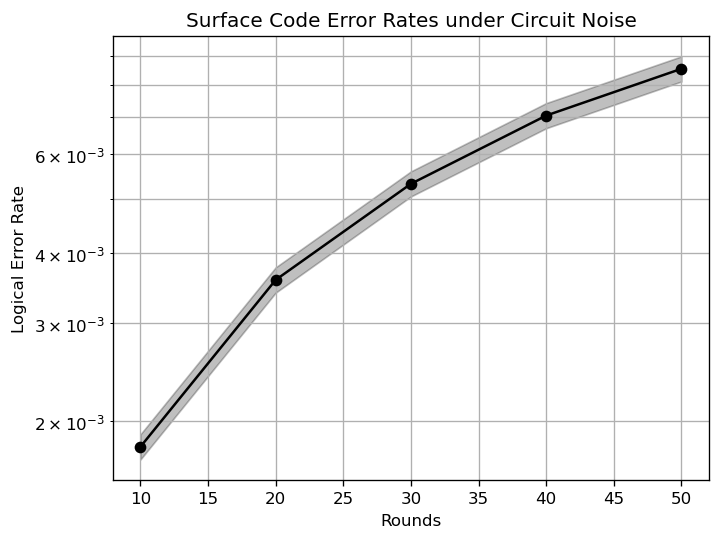

In [237]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['r'],
    # group_func=lambda stat: stat.json_metadata['d'],
    # failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)
# ax.set_ylim(5e-3, 5e-2)
# ax.set_xlim(0.008, 0.012)
ax.semilogy()
ax.set_title("Surface Code Error Rates under Circuit Noise")
ax.set_xlabel("Rounds")
ax.set_ylabel("Logical Error Rate")
ax.grid(which='major')
ax.grid(which='minor')
# ax.legend()
fig.set_dpi(120)  # Show it bigger

In [238]:
collected_surface_code_stats

[sinter.TaskStats(strong_id='ac2af60a921c081df4b75c0f59c28aa6f820d36437272fb1a453e26b83f6fb78', decoder='pymatching', json_metadata={'d': 4, 'r': 10, 'p': 0.001}, shots=2858835, errors=5146, seconds=2.094999999997526),
 sinter.TaskStats(strong_id='0bd66ea2469689a51d8b30524212b19836288e4ebf02eb93393e3f3693f2405f', decoder='pymatching', json_metadata={'d': 4, 'r': 40, 'p': 0.001}, shots=727984, errors=5126, seconds=2.1719999999986612),
 sinter.TaskStats(strong_id='cf8421a3d6faa60dbb297c1534449107786d7237bd311963c801f3941ccc2997', decoder='pymatching', json_metadata={'d': 4, 'r': 20, 'p': 0.001}, shots=1416237, errors=5069, seconds=2.1080000000001746),
 sinter.TaskStats(strong_id='4d0130882b8a23b75e4d871f4fddc17060cddd7f03f8b9be3de647c2d19a48a0', decoder='pymatching', json_metadata={'d': 4, 'r': 30, 'p': 0.001}, shots=968163, errors=5147, seconds=2.2040000000015425),
 sinter.TaskStats(strong_id='f0d1dcf1dfa2af8bf83b5ebe5a5fd83464793e3c1b4f011dbeed0cfe5b3c6bea', decoder='pymatching', json_

In [239]:

for i in range(5):
    shots = collected_surface_code_stats[i].shots
    errors = collected_surface_code_stats[i].errors
    print(1-(1-(errors/shots))**4)

0.007180718305548006
0.027869363389758317
0.014240131864344807
0.021096039151973556
0.033713972264602265


In [4]:
circuit = stim.Circuit.generated(
            "surface_code:unrotated_memory_z",
            rounds=10,
            distance=5,
            after_clifford_depolarization=0.001,
            after_reset_flip_probability=0.001,
            before_measure_flip_probability=0.001,
            before_round_data_depolarization=0.001,
        )
print(circuit)

QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(1, 0) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 0) 3
QUBIT_COORDS(4, 0) 4
QUBIT_COORDS(5, 0) 5
QUBIT_COORDS(6, 0) 6
QUBIT_COORDS(7, 0) 7
QUBIT_COORDS(8, 0) 8
QUBIT_COORDS(0, 1) 9
QUBIT_COORDS(1, 1) 10
QUBIT_COORDS(2, 1) 11
QUBIT_COORDS(3, 1) 12
QUBIT_COORDS(4, 1) 13
QUBIT_COORDS(5, 1) 14
QUBIT_COORDS(6, 1) 15
QUBIT_COORDS(7, 1) 16
QUBIT_COORDS(8, 1) 17
QUBIT_COORDS(0, 2) 18
QUBIT_COORDS(1, 2) 19
QUBIT_COORDS(2, 2) 20
QUBIT_COORDS(3, 2) 21
QUBIT_COORDS(4, 2) 22
QUBIT_COORDS(5, 2) 23
QUBIT_COORDS(6, 2) 24
QUBIT_COORDS(7, 2) 25
QUBIT_COORDS(8, 2) 26
QUBIT_COORDS(0, 3) 27
QUBIT_COORDS(1, 3) 28
QUBIT_COORDS(2, 3) 29
QUBIT_COORDS(3, 3) 30
QUBIT_COORDS(4, 3) 31
QUBIT_COORDS(5, 3) 32
QUBIT_COORDS(6, 3) 33
QUBIT_COORDS(7, 3) 34
QUBIT_COORDS(8, 3) 35
QUBIT_COORDS(0, 4) 36
QUBIT_COORDS(1, 4) 37
QUBIT_COORDS(2, 4) 38
QUBIT_COORDS(3, 4) 39
QUBIT_COORDS(4, 4) 40
QUBIT_COORDS(5, 4) 41
QUBIT_COORDS(6, 4) 42
QUBIT_COORDS(7, 4) 43
QUBIT_COORDS(8, 4) 44
QUBIT_COORDS(0, 5) 4

In [5]:
from scipy.sparse import lil_matrix

dem = circuit.flattened().detector_error_model()
pcm = lil_matrix((dem.num_detectors, dem.num_errors), dtype=np.uint8)
lcm = lil_matrix((dem.num_observables, dem.num_errors), dtype=np.uint8)

errors = []
channel_probs = [e.args_copy()[0] for e in circuit.flattened().detector_error_model() if e.type=="error"]
for i, error_event in enumerate(circuit.explain_detector_error_model_errors()):
    dets = [det.dem_target.val for det in error_event.dem_error_terms if det.dem_target.is_relative_detector_id()]
    obs = [ob.dem_target.val for ob in error_event.dem_error_terms if ob.dem_target.is_logical_observable_id()]
    pcm[[dets],i] = 1
    lcm[[obs],i] = 1

print(pcm.shape)
print(lcm.shape)

(400, 6859)
(1, 6859)


In [12]:
from ldpc import bp_decoder

bp_dec = bp_decoder(
    pcm,
    channel_probs=channel_probs,
    max_iter=pcm.shape[1],
    bp_method="msl",
    ms_scaling_factor=0
)

bposd_dec = bposd_decoder(
    pcm, # the parity check matrix
    channel_probs=channel_probs, #assign error_rate to each qubit. This will override "error_rate" input variable
    max_iter=pcm.shape[1], #the maximum number of iterations for BP)
    bp_method="msl",
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd_cs", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    osd_order=min(pcm.shape[0],10) #the osd search depth
)

count = 0
num_iters = 1000

sampler = circuit.compile_detector_sampler()
for i in tqdm(range(num_iters)):
    detection_events, observable_flips = sampler.sample(1, separate_observables=True)
    guessed_errors = bposd_dec.decode(detection_events[0])
    guessed_obs = (lcm @ guessed_errors) % 2

    if not np.all(observable_flips[0].astype(int) == guessed_obs):
        count += 1
print(count/num_iters)

100%|██████████| 1000/1000 [00:33<00:00, 30.26it/s]

0.0
